In [115]:
""" GetBinancedata - credits to @araujo88 (github) """
from binance.client import Client
from binance.enums import *
import pandas as pd
from datetime import datetime
client = Client('binancepubkey',
                'binanceprivkey')
# valid intervals — 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M


def print_file(pair, interval, name):
    # request historical candle (or klines) data
    bars = client.get_historical_klines(
        pair, interval, "01 Jan, 2018", "18 Nov, 2022")

    # delete unwanted data — just keep date, open, high, low, close
    for line in bars:
        del line[5:]

    # save as CSV file
    df = pd.DataFrame(bars, columns=["date", "open", "high", "low", "close"])

    for index, timeNotFormatted in enumerate(df.date):
        df.date[index] = datetime.fromtimestamp(timeNotFormatted/1000)

    df.set_index("date", inplace=True)
    df.to_csv(name)


print_file("BTCBRL", "1M", "BTC_1M.csv")

C:\Users\vitor\AppData\Local\Temp\ipykernel_19324\1576183243.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.date[index] = datetime.fromtimestamp(timeNotFormatted/1000)


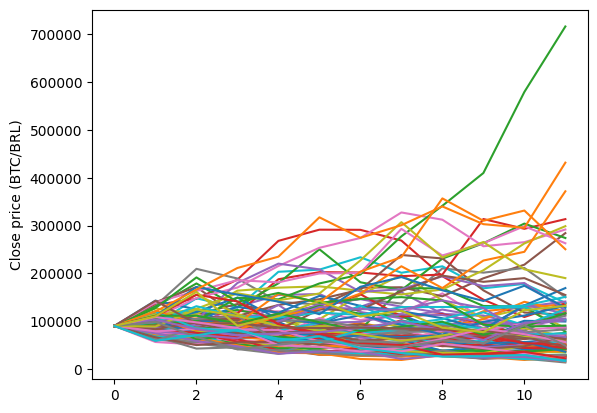

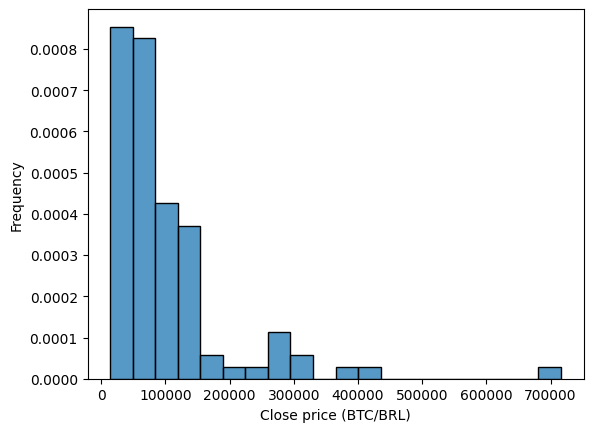

In [2]:
""" Refactored montecarlo.py - credits to @araujo88 (github) """
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import datetime

file = pd.read_csv("BTC_1M.csv", parse_dates=False)

date = pd.to_datetime(file.date)
data = file.close

log_returns = np.log(1 + data.pct_change())
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5*var)

stdev = log_returns.std()
days = 12 # 12 months prediction
iterations = 100
Z = norm.ppf(np.random.rand(days, iterations))
daily_returns = np.exp(drift + stdev * Z)

price_paths = np.zeros_like(daily_returns)
price_paths[0] = data.iloc[-1]
for t in range(1, days):
    price_paths[t] = price_paths[t-1]*daily_returns[t]

base = date.iloc[-1]
future_dates = [base + datetime.timedelta(days=30) for x in range(days)]

#plt.plot(date, data, linestyle='dashed')
plt.plot(price_paths)
plt.ylabel("Close price (BTC/BRL)")
plt.show()

sns.histplot(price_paths[-1,:], bins = 20, stat = "frequency")
plt.xlabel("Close price (BTC/BRL)")
plt.ylabel("Frequency")
plt.show()


In [3]:
# Calcula a média de cada mês e armazena num array do Numpy
monthlyMean = np.array([])
for month in price_paths:
    monthlyMean = np.append(monthlyMean, [month.mean()])

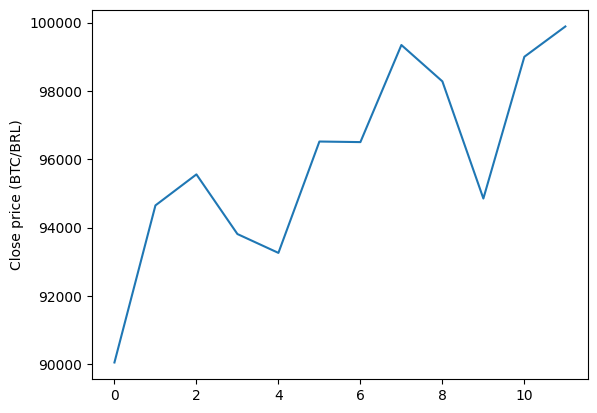

In [57]:
plt.plot(monthlyMean)
plt.ylabel("Close price (BTC/BRL)")
plt.show()

In [104]:
""" Faz a predição das compras futuras por DCA com base nas médias da simulação de montecarlo"""

compraMensal = [200, 400, 1000, 3000, 5000]

btcsAcumulados = dict.fromkeys(compraMensal, [])

def comprarBitcoin(btcPrice, amount):
    return amount / btcPrice

for valor in compraMensal:
    compras = []
    btcs = []
    
    for month in range(12):
        compra = comprarBitcoin(monthlyMean[month], valor)
        btcs.append(sum(compras) + compra)
        compras.append(compra)

    btcsAcumulados[valor] = btcs

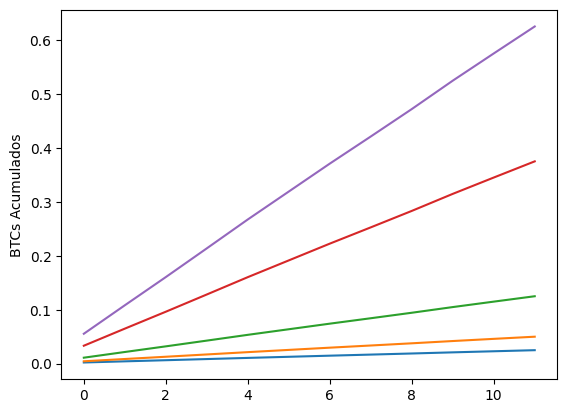

In [107]:
for valor in btcsAcumulados:
    plt.plot(np.array(btcsAcumulados[valor]))

plt.ylabel("BTCs Acumulados")
plt.show()

In [108]:
for valor in compraMensal:
    print(f'A quantidade de BTCs acumulados para compra mensal de R$ {valor} é: {btcsAcumulados[valor][-1]}')

A quantidade de BTCs acumulados para compra mensal de R$ 200 é: 0.02502711406323429
A quantidade de BTCs acumulados para compra mensal de R$ 400 é: 0.05005422812646858
A quantidade de BTCs acumulados para compra mensal de R$ 1000 é: 0.12513557031617142
A quantidade de BTCs acumulados para compra mensal de R$ 3000 é: 0.37540671094851435
A quantidade de BTCs acumulados para compra mensal de R$ 5000 é: 0.6256778515808573
